<a href="https://colab.research.google.com/github/adammuhtar/andy_haldane_speech_analysis/blob/main/Analysis_of_key_risks_mentioned_in_Andy_Haldane's_Speeches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of key risks mentioned in Andy Haldane's Speeches**

*by Adam Muhtar*

---

This notebook contains a natural language processing (NLP) exercise which analyses and summarises the key risks mentioned in the speeches of former Chief Economist of the Bank of England, [Andy Haldane](https://www.bankofengland.co.uk/about/people/andy-haldane/biography).

The notebook consists of the following parts:
1. Setting up the Google Colab notebook environment by installing/upgrading packages relevant for text analysis that is not native to the local Colab environment.
2. Scraping the web for speeches from Andy Haldane, then extracting and 'cleaning' the unstructured text data in order for the dataset to be analysable.
3. Run term frequency analyses to determine the most common recurring risk-related words cited by Andy Haldane, and visualise these findings through *n*-gram barplots.
4. Run a term frequency-inverse document frequency (*tf-idf*) to determine the most distinctively frequent risk-related terms, and visualise these findings through barplots of *n*-gram's *tf-idf* scores.

#### **Notes on Google Colab**
This NLP analysis of Andy Haldane's speeches uses Google Colaboratory (**Colabs**) to run this Python script. Colab is Google's implementation of [Jupyter Notebook](https://jupyter.org/) and like all Jupyter Notebooks, a Colab consists of two kinds of components:

  * **Text cells**, which contain explanations. This cell, for instance, is a text cell.
  * **Code cells**, which contain Python code for the user to run. Code cells have a light gray/black background (depending on the mode being run.

Text cells are to be *read* and code cells are to be *executed*.

#### **Running code cells**

If viewed using Google Colab, execution of code cells must run in order. In other words, the user may only run a code cell once all the code cells preceding it have already been run. 

To run a code cell:

  1. Place the cursor anywhere inside the [ ] area at the top left of a code cell. The area inside the [ ] will display an arrow.
  2. Click the arrow.

Alternatively, the user may invoke **Runtime → Run all**.

For ease of reading, please navigate this notebook using the table of contents (if viewed using Google Colab, this is accessible via the three-dots-and-bars icon on the left-hand side).

## **Setting up Google Colab notebook**
---
We first set up our Colab notebook by installing/updating text mining library [`pdfplumber`](https://pypi.org/project/pdfplumber/) into the local Colab environment.

In [1]:
#@title Install latest version of packages relevant for text analysis
# Refer to https://github.com/jsvine/pdfplumber for documentation
!pip install --upgrade pdfplumber

     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 5.6 MB 7.0 MB/s 
     |████████████████████████████████| 4.3 MB 36.6 MB/s 
     |████████████████████████████████| 139 kB 59.0 MB/s 
     |████████████████████████████████| 3.6 MB 27.9 MB/s 
  Created wheel for pdfplumber: filename=pdfplumber-0.6.0-py3-none-any.whl size=33688 sha256=1d1a0757fd04ea046e4cfa5b1322741183b8dd70e18fc08a3b754900d4e661a2
  Stored in directory: /root/.cache/pip/wheels/58/56/fe/2e93d842ffa9ea97746c1ab253d43502ed61c0689361a0224e
Successfully built pdfplumber
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is inc

## **Web scraping, text extraction, and text pre-processing Andy Haldane's speeches**
---
This section details the text mining operations conducted in order to analyse his speeches; these include codes that runs web scraping, text extraction and conversion to plain text, word tokenisation, and stop word removal processes. The speeches themselves are sourced from the Bank of England's website, available [here](https://www.bankofengland.co.uk/news/speeches) by filtering on Andy Haldane.

In total, 73 of 76 speeches given by Andy Haldane during his time as Chief Economist at the Bank of England are mined for this analysis; the remaining 3 speeches ([here](https://www.bankofengland.co.uk/speech/2020/the-health-wealth-and-happiness-of-nations-slides-by-andy-haldane), [here](https://www.bankofengland.co.uk/speech/2016/slides-from-andy-haldanes-speech-given-at-the-deans-lecture-at-cass-business-school), and [here](https://www.bankofengland.co.uk/speech/2016/andy-haldanes-opening-remarks-at-lbs-centre-for-corporate-governance-and-boe-fintech-conference)) are missing as the sites themselves do not contain the speeches.

In [2]:
#@title Create a directory to house all downloaded speeches
import os                           # interacting with the operating system


# Create a new directory "speeches"
speech_dir = "/content/speeches"    # file path should be changed accordingly
os.mkdir(speech_dir)

In [3]:
#@title Change working directory
%cd speeches

/content/speeches


In [4]:
#@title Web scraping speech PDFs from the Bank of England sites
import requests


# URLs of Andy Haldane's speeches
urls = [
        # "https://www.bankofengland.co.uk/speech/2021/june/andy-haldane-speech-at-the-institute-for-government-on-the-changes-in-monetary-policy", # no PDF
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2021/february/inflation-a-tiger-by-the-tail-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2020/what-has-central-bank-independence-ever-done-for-us-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2020/seizing-the-opportunities-from-digital-finance-speech-by-andy-haldane.pdf",
        # "https://www.bankofengland.co.uk/speech/2020/andy-haldane-engaging-business-summit-and-autumn-lecture", # no PDF
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2020/avoiding-economic-anxiety-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2020/the-second-quarter-speech-by-andy-haldane.pdf",
        # "https://www.bankofengland.co.uk/speech/2020/the-health-wealth-and-happiness-of-nations-slides-by-andy-haldane", # only slides
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2019/understanding-pay-gaps-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2019/climbing-the-jobs-ladder-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2019/is-all-economics-local-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2019/the-creative-economy-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2018/pay-power-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2018/folk-wisdom-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2018/market-power-and-monetary-policy-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2018/the-uks-productivity-problem-hub-no-spokes-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2018/ideas-and-institutions-a-growth-story-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2018/will-big-data-keep-its-promise-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2018/how-monetary-policy-affects-your-gdp-speech-by-andy-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2018/climbing-the-public-engagement-ladder.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2017/everyday-economics.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2017/rethinking-financial-stability.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2017/work-wages-and-monetary-policy.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2017/a-little-more-conversation-a-little-less-action.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2017/productivity-puzzles.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2016/one-car-two-car-red-car-blue-car.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2016/the-diversity-project.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2016/the-dappled-world.pdf",
        # "https://www.bankofengland.co.uk/speech/2016/slides-from-andy-haldanes-speech-given-at-the-deans-lecture-at-cass-business-school" only slides
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2016/whose-recovery.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2016/the-great-divide.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2016/the-sneetches.pdf",
        # "https://www.bankofengland.co.uk/speech/2016/andy-haldanes-opening-remarks-at-lbs-centre-for-corporate-governance-and-boe-fintech-conference", only slides
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2015/labours-share.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2015/how-low-can-you-can-go.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2015/who-owns-a-company.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2015/stuck.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2015/on-microscopes-and-telescopes.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2015/drag-and-drop.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2015/growing-fast-and-slow.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2014/central-bank-psychology.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2014/managing-global-finance-as-a-system.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2014/twin-peaks.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2014/in-giving-how-much-do-we-receive-the-social-value-of-volunteering.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2014/the-corridor-of-uncertainty.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2014/unfair-shares.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2014/the-age-of-asset-management.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2014/ambidexterity.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2013/the-commercial-property-forum-twenty-years-on.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2013/why-institutions-matter-now-more-than-ever.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2013/turning-the-red-tape-tide.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2012/a-leaf-being-turned.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2012/on-being-the-right-size.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2012/the-bank-and-the-banks.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2012/tails-of-the-unexpected.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2012/on-counterparty-risk.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2012/financial-arms-races.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2012/accounting-for-bank-uncertainty.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2011/control-rights-and-wrongs-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2011/risk-off-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2011/haircuts-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2011/the-race-to-zero-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2011/the-short-long-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2011/the-big-fish-small-pond-problem-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2011/capital-discipline-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2010/curbing-the-credit-cycle-speech.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2010/global-imbalances-in-retrospect-and-prospect-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2010/patience-and-finance-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2010/the-contribution-of-the-financial-sector-miracle-or-mirage-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2010/the-100-billion-question-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2010/fair-value-in-foul-weather-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2010/the-debt-hangover-speech-by-andrew-haldane.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2009/credit-is-trust.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2009/small-lessons-from-a-big-crisis.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2009/rethinking-the-financial-network.pdf",
        "https://www.bankofengland.co.uk/-/media/boe/files/speech/2009/why-banks-failed-the-stress-test.pdf"
]


# Scraping PDFs from URLs
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        file_path = os.path.join(speech_dir, os.path.basename(url))
        with open(file_path, "wb") as f:
            f.write(response.content)

In [5]:
#@title Text extraction from PDFs
import pdfplumber               # PDF text extraction


# Create a list of PDF file names and text file names
pdf_list = os.listdir(speech_dir)
txt_list = [pdf[:-4] + ".txt" for pdf in pdf_list]


# Extracting text and saving output in dictionary
for i in range(0, len(pdf_list)):
    out = open(txt_list[i], "wt")  # open text output
    with pdfplumber.open(os.fsdecode(pdf_list[i])) as pdf:
        for pdf_page in pdf.pages:
            page_text = pdf_page.extract_text()
            out.write(page_text)
        out.close()

In [6]:
#@title Pre-processing text files
import pandas as pd             # data processing, CSV file I/O
import re                       # regular expression operations
import string                   # string formatting functions
import unicodedata              # unicode normalisation


# Create a list of speech titles without any suffix
speech = [pdf[:-4] for pdf in pdf_list]


# Read text files as CSV files into a dictionary
d1 = {}

for i in range(0, len(speech)):
    d1[speech[i]] = pd.read_csv(
        txt_list[i], delimiter = "\n", names = ["text"]
    )
    # concatenate all rows into one row
    d1[speech[i]]["text"] = d1[speech[i]]["text"].str.cat(sep = " ")
    # dataframe now redundant, replace it with one of the rows 
    d1[speech[i]] = d1[speech[i]]["text"][0]
    # convert string to lowercases
    d1[speech[i]] = d1[speech[i]].lower()
    # translating unicode strings into normal characters
    d1[speech[i]] = unicodedata.normalize("NFKD", d1[speech[i]])
    # remove punctuation symbols
    d1[speech[i]] = d1[speech[i]].translate(
        str.maketrans(
            "", "",string.punctuation[:12] + string.punctuation[13:]
        )
    )
    # remove excess whitespaces
    d1[speech[i]] = re.sub(" +", " ", d1[speech[i]])


# Remove repeating strings
del_strings = [
               "all speeches are available online at",
               "all speeches are available online",
               "all speeches available online",
               "speeches are available online at",
               "speeches available online at",
               "speeches available online",
               "wwwbankofenglandcoukpublicationspagesspeechesdefaultaspx",
               "wwwbankofenglandcoukpublicationsspeeches",
               "wwwbankofenglandcouknewsspeeches",
               "wwwbankofenglandcoukspeeches",
               "boepressoffice",
               "remarks by",
               "speech given by",
               "andrew g haldane",
               "andy haldane",
               "the views are not necessarily those of the bank of england or the monetary policy committee",
               "the views are not necessarily those of the bank of england or the financial policy committee",
               "the views expressed within are not necessarily those of the bank of england or the monetary policy committee",
               "the views expressed within are not necessarily those of the bank of england or the financial policy committee",
               "i would like to thank",
               "and the staff of the bank’s archives", 
               "for comments and contributions",
               "for their comments and contributions",
               "et al"
]

for i in range(0, len(speech)):
    for j in range(0, len(del_strings)):
        # d1[speech[i]] = d1[speech[i]].replace(del_strings[j], "")
        d1[speech[i]] = re.sub(del_strings[j], " ", d1[speech[i]])
        # remove excess whitespaces
        d1[speech[i]] = re.sub(" +", " ", d1[speech[i]])


# Remove refences section
for i in range(0, len(speech)):
    if re.search("references", d1[speech[i]]):
        # use greedy regex to remove all strings after the last "references"
        d1[speech[i]] = re.findall(".*references", d1[speech[i]])
        d1[speech[i]] = d1[speech[i]][0]
    else:
        pass

In [7]:
#@title Tokenisation and stop words removal
import nltk                     # language processing operations
nltk.download("punkt")
nltk.download("stopwords")

from nltk.tokenize import word_tokenize


# Tokenise speech words
d2 = {}
for i in range(0, len(speech)):
    d2[speech[i]] = word_tokenize(d1[speech[i]])


# Remove stop words
stopwords = nltk.corpus.stopwords.words("english")

for i in range(0, len(speech)):
    d2[speech[i]] = [word for word in d2[speech[i]] if word not in stopwords]
    d2[speech[i]] = " ".join(d2[speech[i]])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
#@title Web scraping, text extraction, tokenisation, and stop word removal from HTML pages (BoE sites without PDFs)
from urllib.request import urlopen
from bs4 import BeautifulSoup

url_html = [
            "https://www.bankofengland.co.uk/speech/2021/june/andy-haldane-speech-at-the-institute-for-government-on-the-changes-in-monetary-policy",
            "https://www.bankofengland.co.uk/speech/2020/andy-haldane-engaging-business-summit-and-autumn-lecture",
]

speech_html = []
for i in range(0, len(url_html)):
    speech_html.append(url_html[i].split("andy-haldane-", 1)[1])


# Parsing HTML using BeautifulSoup
soup = {}
for i in range(0, len(url_html)):
    html = urlopen(url_html[i]).read()
    soup[i] = BeautifulSoup(html, features = "html.parser")


# Extracting and cleaning text (largely a repeat of the above)
d3 = {}

for i in range(0, len(soup)):
    d3[speech_html[i]] = soup[i].get_text()
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in d3[speech_html[i]].splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    d3[speech_html[i]] = " ".join(chunk for chunk in chunks if chunk)
    # convert string to lowercases
    d3[speech_html[i]] = d3[speech_html[i]].lower()
    # translating unicode strings into normal characters
    d3[speech_html[i]] = unicodedata.normalize("NFKD", d3[speech_html[i]])
    # remove punctuation symbols
    d3[speech_html[i]] = d3[speech_html[i]].translate(
        str.maketrans(
            "", "",string.punctuation[:12] + string.punctuation[13:]
        )
    )
    # remove excess whitespaces
    d3[speech_html[i]] = re.sub(" +", " ", d3[speech_html[i]])
    # extract only parts after "published on" and before "references"
    for j in range(0, len(del_strings)):
        # d1[speech[i]] = d1[speech[i]].replace(del_strings[j], "")
        d3[speech_html[i]] = re.sub(del_strings[j], " ", d3[speech_html[i]])
        # remove excess whitespaces
        d3[speech_html[i]] = re.sub(" +", " ", d3[speech_html[i]])
    d3[speech_html[i]] = d3[speech_html[i]].split("published on", 1)[1]
    d3[speech_html[i]] = d3[speech_html[i]].split("references", 1)[0]


# Tokenise speech words (same as above)
d4 = {}
for i in range(0, len(speech_html)):
    d3[speech_html[i]] = word_tokenize(d3[speech_html[i]])


# Remove stop words (same as above)
for i in range(0, len(speech_html)):
    d3[speech_html[i]] = [word for word in d3[speech_html[i]] if word not in stopwords]
    d3[speech_html[i]] = " ".join(d3[speech_html[i]])


In [10]:
#@title Create dataframe of speech titles, texts, and tokens
# Combine elements from d1 and d2 first
speeches = pd.DataFrame(data = {"speech": speech})
speeches["text"] = speeches["speech"].map(d1)
speeches["token"] = speeches["speech"].map(d2)

# Create a temporary dataframe that combines elements from d3 and d4
temp = pd.DataFrame(data = {"speech": speech_html})
temp["text"] = temp["speech"].map(d3)
temp["token"] = temp["speech"].map(d3)

# Merge both dataframes
speeches = pd.concat([speeches, temp], ignore_index = True)
speeches

,speech,text,token
0,the-age-of-asset-management,the age of asset management executive director...,age asset management executive director financ...
1,inflation-a-tiger-by-the-tail-speech-by-andy-h...,inflation a tiger by the tail chief economist ...,inflation tiger tail chief economist member mo...
2,control-rights-and-wrongs-speech-by-andrew-hal...,control rights and wrongs executive director f...,control rights wrongs executive director finan...
3,fair-value-in-foul-weather-speech-by-andrew-ha...,fair value in foul weather executive director ...,fair value foul weather executive director fin...
4,climbing-the-public-engagement-ladder,climbing the public engagement ladder chief ec...,climbing public engagement ladder chief econom...
...,...,...,...
68,financial-arms-races,financial arms races executive director financ...,financial arms races executive director financ...
69,the-great-divide,the great divide chief economist bank of engla...,great divide chief economist bank england new ...
70,on-counterparty-risk,lead comment on counterparty risk receivedinre...,lead comment counterparty risk receivedinrevis...
71,speech-at-the-institute-for-government-on-the-...,30 june 2021 last day chief economist shares e...,30 june 2021 last day chief economist shares e...


## **Term frequency analyses and *n*-grams plots (unigrams, bigrams, trigrams, and 4-grams)**
---
Given that the main topic of interest here is in identifying instances in which Andy has touched on the topic of risk and risk-related matters, the first task is to find instances in which the tokenised text matches with a word that is listed in a set of pre-defined trigger phrases (shown below as `risk_stem_words`). The operation below searches for any instance in which the tokens matches with one of the trigger phrases, and then takes in a set number of characters preceding and after these tokens to capture the content of interest.

In [11]:
#@title Create token list containing relevant risk terms
# Define stem words related to risk (stemmed to include various derivative forms)
risk_stem_words = ["risk", "hazard", "danger", "uncertain", "unpredictab",
                   "instablility", "unstable", "threat", "crash", "contagio",
                   "fail"]


# Compile list of tokens containing relevant risk terms
speeches["risk-centred token"] = ""

for i in range(0, len(speeches)):
    for j in range(0, len(risk_stem_words)):
        temp = " ".join(re.findall(
            '.{40}' + re.escape(risk_stem_words[j]) + '.{40}',
            speeches["token"][i]
        ))
        speeches["risk-centred token"][i] = (speeches["risk-centred token"][i]
                                             + " " + temp)
        # remove excess whitespaces
        speeches["risk-centred token"][i] = re.sub(
            " +", " ", speeches["risk-centred token"][i]
        )

speeches

,speech,text,token,risk-centred token
0,the-age-of-asset-management,the age of asset management executive director...,age asset management executive director financ...,ponse regulators globally begun explore risks...
1,inflation-a-tiger-by-the-tail-speech-by-andy-h...,inflation a tiger by the tail chief economist ...,inflation tiger tail chief economist member mo...,tral banks assess future path inflation risks...
2,control-rights-and-wrongs-speech-by-andrew-hal...,control rights and wrongs executive director f...,control rights wrongs executive director finan...,ge consequences historical distribution risks...
3,fair-value-in-foul-weather-speech-by-andrew-ha...,fair value in foul weather executive director ...,fair value foul weather executive director fin...,l ” – application fair value principles risks...
4,climbing-the-public-engagement-ladder,climbing the public engagement ladder chief ec...,climbing public engagement ladder chief econom...,scal external trust understanding carry dange...
...,...,...,...,...
68,financial-arms-races,financial arms races executive director financ...,financial arms races executive director financ...,etry imperfections information generate risk ...
69,the-great-divide,the great divide chief economist bank of engla...,great divide chief economist bank england new ...,ed-corn future growth5 also help insure risk ...
70,on-counterparty-risk,lead comment on counterparty risk receivedinre...,lead comment counterparty risk receivedinrevis...,adequacy management counterparty credit risk ...
71,speech-at-the-institute-for-government-on-the-...,30 june 2021 last day chief economist shares e...,30 june 2021 last day chief economist shares e...,policy strategies pursued central banks risk ...


---

The next step involves create *n*-grams for these "risk-centred" tokens; that is, the contiguous sequence of *n* items surrounding the key token of interest. These *n*-grams are then through a word frequency counter that tallies their count to obtain the most common sub-phrases mentioned in his speeches. 

The [`sklearn`](https://scikit-learn.org) package is used here to compute the term frequencies, using a function called [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

---

In [12]:
#@title Convert risk-centred tokens into a matrix of token counts
import numpy as np              # linear algebra
from sklearn.feature_extraction.text import CountVectorizer


# Create dataframe for unigram
vectoriser = CountVectorizer(
    stop_words = stopwords, ngram_range = (1, 1), max_features = 300
)
unigrams_df = (
    pd.DataFrame(
        vectoriser.fit_transform(speeches["risk-centred token"]).toarray(),
        columns = vectoriser.get_feature_names(),
    )
    .T.sum(axis = 1)
    .sort_values(ascending = False)
)


# Create dataframe for bigram
vectoriser = CountVectorizer(
    stop_words = stopwords, ngram_range = (2, 2), max_features = 300
)
bigrams_df = (
    pd.DataFrame(
        vectoriser.fit_transform(speeches["risk-centred token"]).toarray(),
        columns = vectoriser.get_feature_names(),
    )
    .T.sum(axis = 1)
    .sort_values(ascending = False)
)


# Create dataframe for trigram
vectoriser = CountVectorizer(
    stop_words = stopwords, ngram_range = (3, 3), max_features = 300
)
trigrams_df = (
    pd.DataFrame(
        vectoriser.fit_transform(speeches["risk-centred token"]).toarray(),
        columns = vectoriser.get_feature_names(),
    )
    .T.sum(axis = 1)
    .sort_values(ascending = False)
)

# Create dataframe for bigram
vectoriser = CountVectorizer(
    stop_words = stopwords, ngram_range = (4, 4), max_features = 300
)
fourgrams_df = (
    pd.DataFrame(
        vectoriser.fit_transform(speeches["risk-centred token"]).toarray(),
        columns = vectoriser.get_feature_names(),
    )
    .T.sum(axis = 1)
    .sort_values(ascending = False)
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

---

Listing the top trigrams and 4-grams, we can observe the relative frequency at which Andy Haldane mentions risk-related terms in different context. Some key observations:
* Risk related to the banking sector; these are linked to issues such as capital adequacy, risk-weighting of assets, leverage (e.g. "balance sheet risk", "risk taking incentives", "risk premium")
* Risks related to financial markets; these are linked to issues relating to market crashes and panic.
* Risks from a sectoral/industrial perspective (e.g. "company specific risk").
* There is also the a small proportion of mentions relating to potential problems of falling "behind", either from the Bank's end or the financial sector as a whole.

---

In [13]:
trigrams_df.head(20)

risk taking incentives       26
stock market crash           12
big fail problem             11
risk free rate               11
risk weighted capital        10
excessive risk taking         9
financial stability risks     8
balance sheet risk            8
risk based capital            6
company specific risk         6
risk weighted assets          6
specific risk premium         6
uncertainty distinct risk     6
failed keep pace              5
financial system whole        5
panic ensued uncertainty      4
policy committee fpc          4
risks financial system        4
big bank failure              4
global financial crisis       4
dtype: int64

In [14]:
fourgrams_df.head(20)

company specific risk premium                 5
uncertainty knightian sense distinct          4
uncertainty causes contagious consequences    4
ensued uncertainty causes contagious          4
knightian sense distinct risk                 4
panic ensued uncertainty causes               4
better job adjusting risk                     4
post crash economics society                  3
crash economics society survey                3
economics society survey 2015                 3
european systemic risk board                  3
lending risky assets backed                   3
1987 stock market crash                       3
risk based capital standards                  3
risk weighted capital ratio                   3
risks becoming self fulfilling                3
stock market crash 1929                       3
stock market crash october                    3
super spreaders financial contagion           3
taking us housing market                      3
dtype: int64

The most interesting "risk-centred" tokens *n*-gram plots shown below are the trigram and 4-gram plots.

The unigram and bigram plots are also shown for completeness.

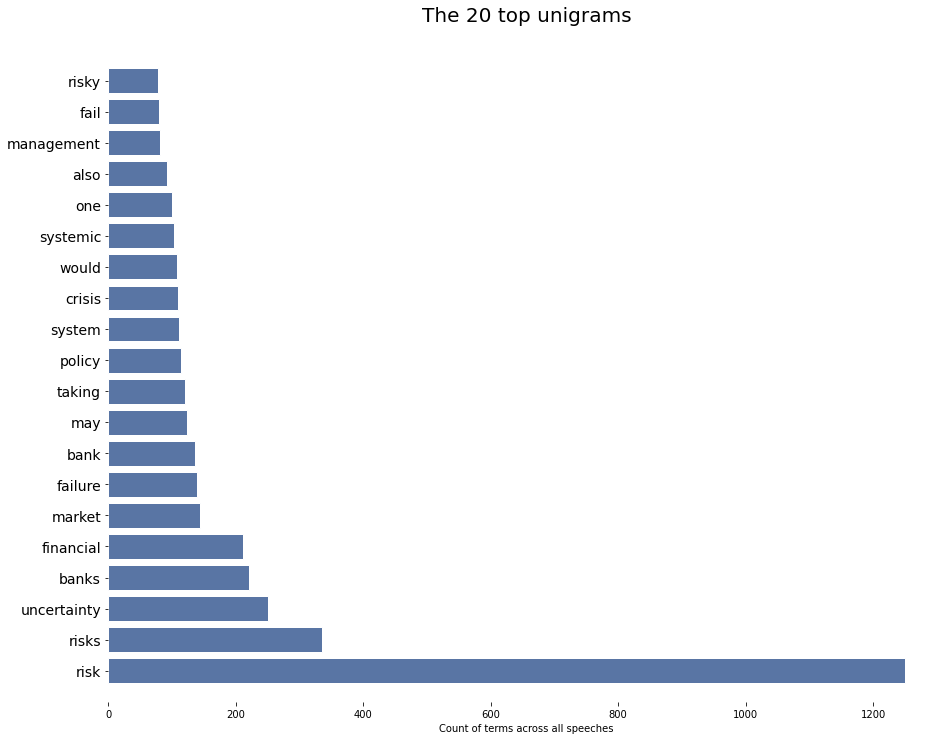

In [15]:
#@title Unigram plot
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize = (15, 12))


# Barplot
num = 20    # number of trigrams to plot
sns.set(font_scale = 2)
sns.set_theme(style="whitegrid")
sns.barplot(
    x = unigrams_df[:num].values,
    y = unigrams_df[:num].index,
    color = "b"
)
ax.set_yticklabels(unigrams_df[:num].index, fontsize = 14)
ax.set_ylim(-1, num)
ax.set_xlabel("Count of terms across all speeches")
ax.set_title(f"The {num} top unigrams\n", fontsize = 20)
sns.despine(left = True, bottom = True)

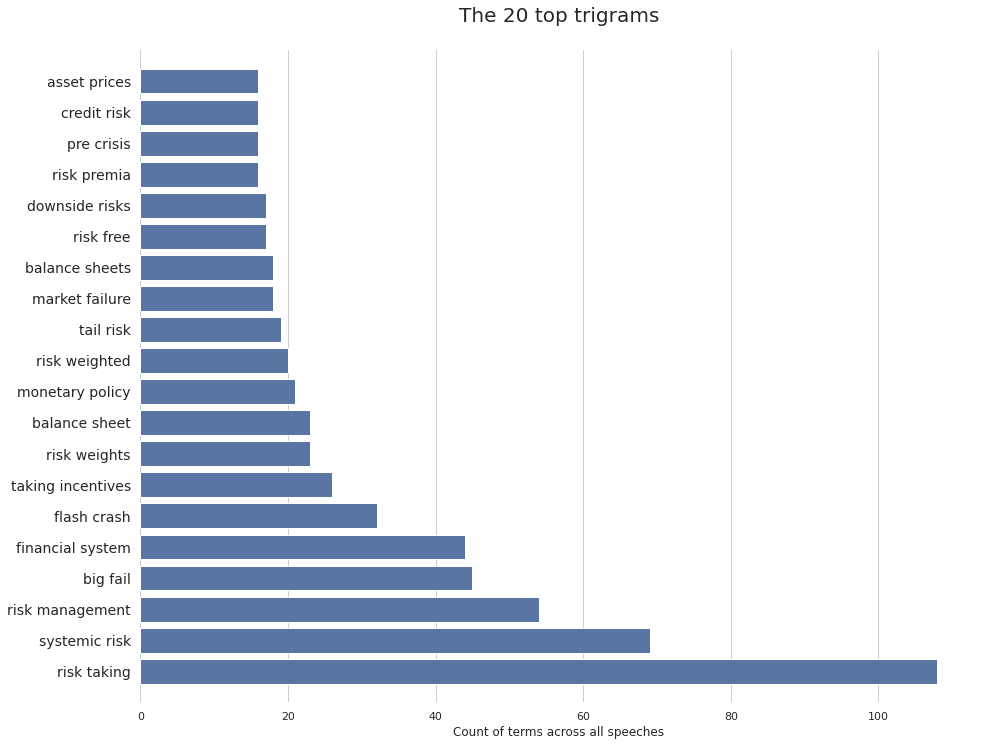

In [16]:
#@title Bigram plot
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize = (15, 12))


# Barplot
num = 20    # number of trigrams to plot
sns.set(font_scale = 2)
sns.set_theme(style="whitegrid")
sns.barplot(
    x = bigrams_df[:num].values,
    y = bigrams_df[:num].index,
    color = "b"
)
ax.set_yticklabels(bigrams_df[:num].index, fontsize = 14)
ax.set_ylim(-1, num)
ax.set_xlabel("Count of terms across all speeches")
ax.set_title(f"The {num} top trigrams\n", fontsize = 20)
sns.despine(left = True, bottom = True)

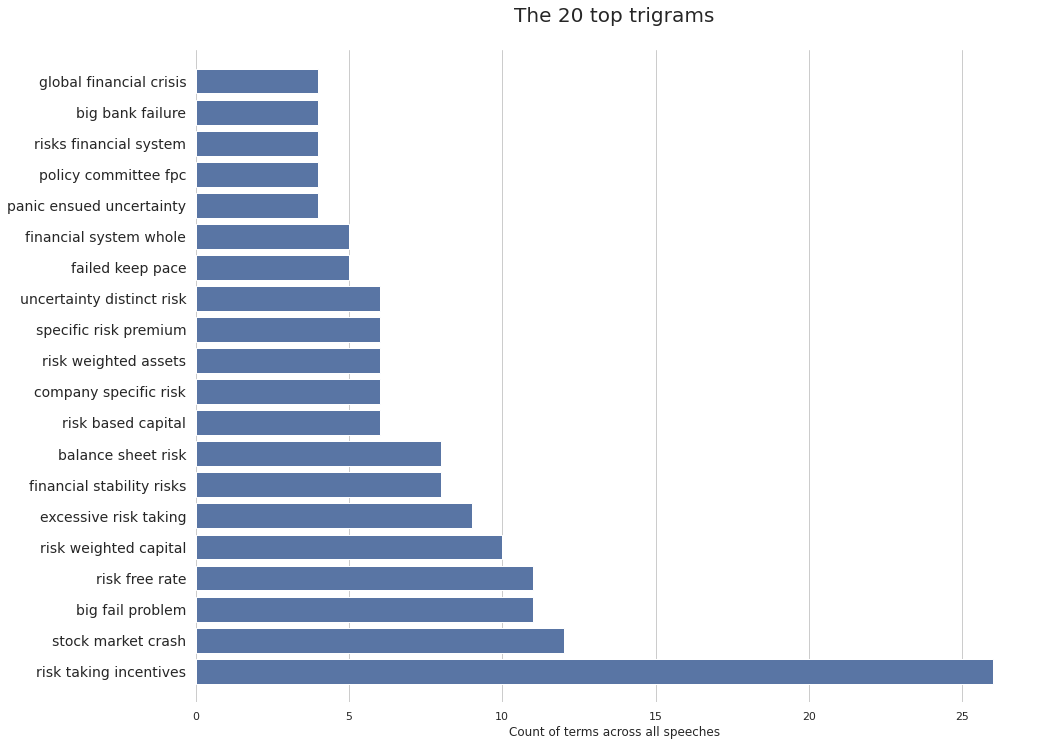

In [17]:
#@title Trigram plot
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize = (15, 12))


# Barplot
num = 20    # number of trigrams to plot
sns.set(font_scale = 2)
sns.set_theme(style="whitegrid")
sns.barplot(
    x = trigrams_df[:num].values,
    y = trigrams_df[:num].index,
    color = "b"
)
ax.set_yticklabels(trigrams_df[:num].index, fontsize = 14)
ax.set_ylim(-1, num)
ax.set_xlabel("Count of terms across all speeches")
ax.set_title(f"The {num} top trigrams\n", fontsize = 20)
sns.despine(left = True, bottom = True)

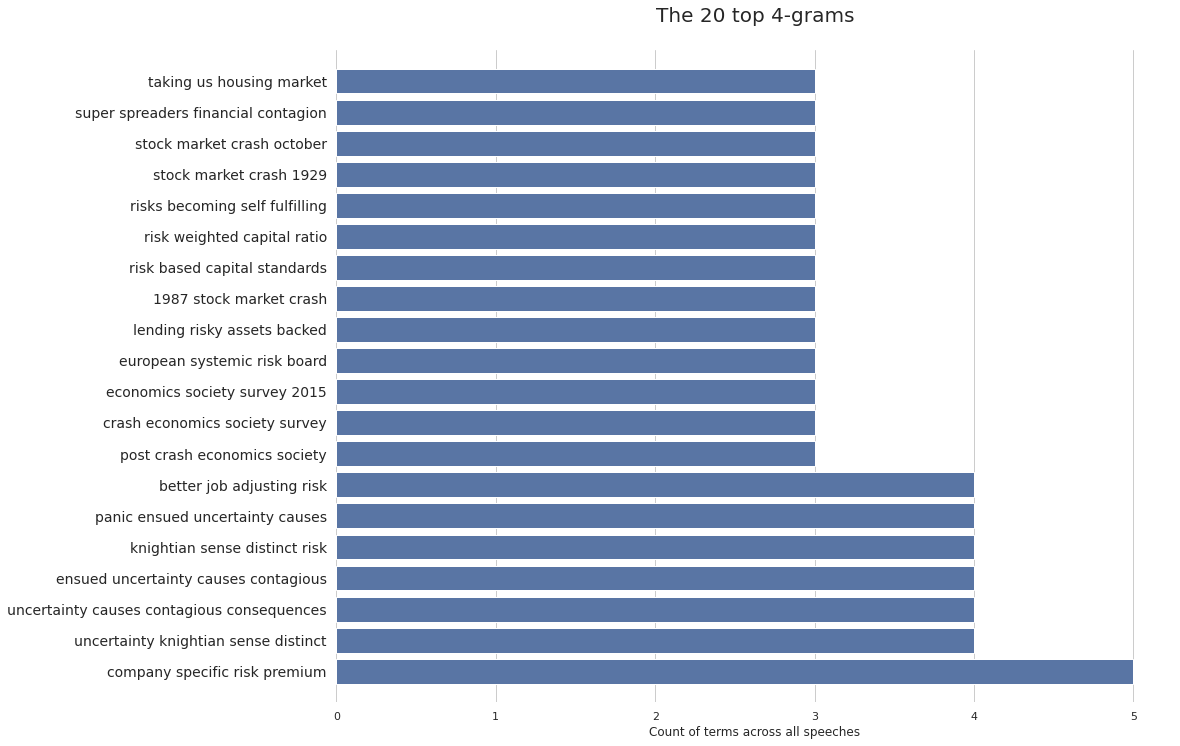

In [18]:
#@title 4-gram plot
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize = (15, 12))


# Barplot
num = 20    # number of trigrams to plot
sns.set(font_scale = 2)
sns.set_theme(style="whitegrid")
sns.barplot(
    x = fourgrams_df[:num].values,
    y = fourgrams_df[:num].index,
    color = "b"
)
ax.set_yticklabels(fourgrams_df[:num].index, fontsize = 14)
ax.set_ylim(-1, num)
ax.set_xlabel("Count of terms across all speeches")
ax.set_title(f"The {num} top 4-grams\n", fontsize = 20)
sns.despine(left = True, bottom = True)

## **Term frequency-inverse document frequency (tf-idf))**
---
Term frequency-inverse document frequency (often referred to as *tf-idf*), is an alternative measure of term counts that is weighted to try and identify the most *distinctively* frequent terms in a given corpus. This type of count can be applied on any *n*-grams, (unigrams, bigrams, etc.).

*Tf-idf* has two parts:
* the term-frequency (denoted below as $t$), which upweights according to counts of terms), and
* an inverse document frequency (denoted below as $s$), which downweights terms that appear frequently across the corpus.

In this analysis, $t$ represents words while Andy Haldane's speeches are the rows for in the `speeches` dataframe. The formula for term frequency is:

$$
{\displaystyle \mathrm {tf} (t,s)={\frac {f_{t,s}}{\sum _{t'\in s}{f_{t',s}}}}}
$$

where $f_{t,d}$ represents the frequency of term $t$ in speech $s$.The [`sklearn`](https://scikit-learn.org) package is once again used here to compute each term's *tf-idf* score, using a function called [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [19]:
#@title Convert risk-centred tokens into a matrix of tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer


# Create dataframe for trigram tf-idf scores
tfidf_vectoriser = TfidfVectorizer(
    stop_words = stopwords, ngram_range = (3, 3), sublinear_tf = True
)
X = tfidf_vectoriser.fit_transform(speeches["risk-centred token"])
trigram_tfidf = (
    pd.DataFrame(X.toarray(), columns = tfidf_vectoriser.get_feature_names())
    .T.sum(axis = 1)
    .sort_values(ascending = False)
)


# Create dataframe for 4-gram tf-idf scores
tfidf_vectoriser = TfidfVectorizer(
    stop_words = stopwords, ngram_range = (4, 4), sublinear_tf = True
)
X = tfidf_vectoriser.fit_transform(speeches["risk-centred token"])
fourgram_tfidf = (
    pd.DataFrame(X.toarray(), columns = tfidf_vectoriser.get_feature_names())
    .T.sum(axis = 1)
    .sort_values(ascending = False)
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


---

Beyond the standard issues of risk highlighted above, an interesting point to note from the ranked *tf-idf* tri and 4-gram scores (shown below) is the that a *distinct* forms of risk mentioned by Andy Haldane relates with the concepts of ***complexity*** and ***forecasting***. This ties with the standard 4-gram plot earlier in this notebook, which includes mentions of concepts such as ***contagion*** and ***Knightian uncertainty***.

---

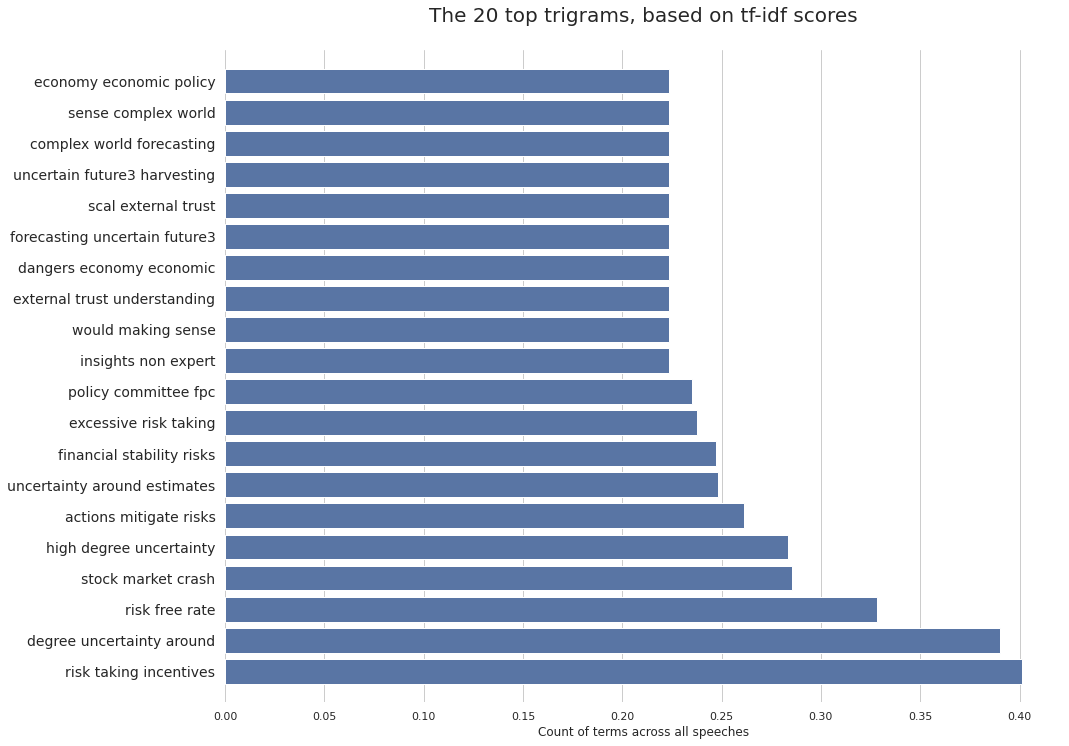

In [20]:
#@title Trigram tf-idf plot
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize = (15, 12))


# Barplot
num = 20    # number of trigrams to plot
sns.set(font_scale = 2)
sns.set_theme(style="whitegrid")
sns.barplot(
    x = trigram_tfidf[:num].values,
    y = trigram_tfidf[:num].index,
    color = "b"
)
ax.set_yticklabels(trigram_tfidf[:num].index, fontsize = 14)
ax.set_ylim(-1, num)
ax.set_xlabel("Count of terms across all speeches")
ax.set_title(f"The {num} top trigrams, based on tf-idf scores\n", fontsize = 20)
sns.despine(left = True, bottom = True)

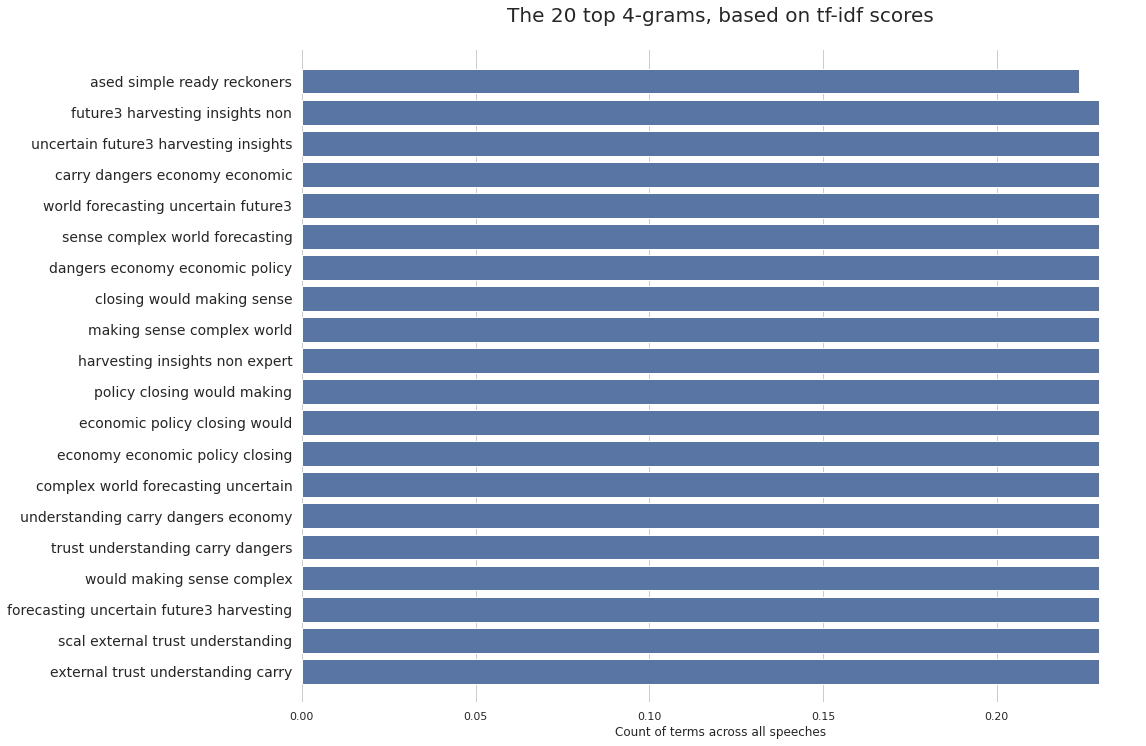

In [21]:
#@title 4-gram tf-idf plot
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize = (15, 12))


# Barplot
num = 20    # number of trigrams to plot
sns.set(font_scale = 2)
sns.set_theme(style="whitegrid")
sns.barplot(
    x = fourgram_tfidf[:num].values,
    y = fourgram_tfidf[:num].index,
    color = "b"
)
ax.set_yticklabels(fourgram_tfidf[:num].index, fontsize = 14)
ax.set_ylim(-1, num)
ax.set_xlabel("Count of terms across all speeches")
ax.set_title(f"The {num} top 4-grams, based on tf-idf scores\n", fontsize = 20)
sns.despine(left = True, bottom = True)

## **Named entity recognition analysis**
---
As an extra bit of exploratory analysis, the following details the named entity recognition analysis—a subtask of information extraction that seeks to locate and classify named entities mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

*N.B.: Running this analysis is computationally taxing (at least on my laptop!) and only a sample text is analysed, as shown below.*

In [22]:
#@title Sample text selection
selected_test = re.findall(
    '.{150}' + re.escape(risk_stem_words[0]) + '.{86}',
    speeches["text"][10]
)[0]
selected_test

' market failures and market frictions exposed within the financial system during the crisis deep reflecting the severity of the hit to balance sheets risk appetite and economic activity that the crisis has inflicted and continues to inflict'

In [23]:
#@title Visualising named entities and their labels
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

displacy.serve(nlp(selected_test), style = "ent")

/usr/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.
